In [1122]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Dropout
from sklearn.metrics import mean_absolute_error
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from matplotlib import dates as mlp_dates
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [1123]:
%matplotlib inline

In [1124]:
first_data = pd.read_csv('water_data.csv')

In [1125]:
columns = ['Date', 'Drawdown', 'Rainfall', 'Water Level']  
first_data = first_data[columns]

In [1126]:
first_data['Rainfall'] = pd.to_numeric(first_data['Rainfall'], errors='coerce')

# Split data into training and testing sets
train_size = int(len(first_data) * 0.8)
train_data = first_data.iloc[:train_size]
test_data = first_data.iloc[train_size:]

# Calculate means from training data
water_mean = train_data['Water Level'].mean()
drawdown_mean = train_data['Drawdown'].mean()

# Fill missing values with means
data = first_data.fillna(value={'Drawdown': drawdown_mean, 'Rainfall': 0, 'Water Level': water_mean,}).copy()

# Convert 'Date' column to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')
data.set_index('Date', inplace=True)


In [1127]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [1128]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 5
X_train, y_train = create_sequences(scaled_data[:train_size], seq_length)
X_test, y_test = create_sequences(scaled_data[train_size:], seq_length)

In [1129]:
# model architecture to output a single value
input_shape = X_train.shape[1:]
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(LSTM(units=32))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu'))  # Add a dense layer with 64 units and ReLU activation
model.add(Dense(1))

# Compile the LSTM model
adam = Adam(learning_rate=0.1)
model.compile( loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [1130]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='model_weights.weights.h5', monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

CPU times: total: 0 ns
Wall time: 1.99 ms


In [1131]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=59, callbacks=[es, rlr, mcp, tb], validation_split=0.2, batch_size=64, verbose=1)

Epoch 1/59
71/77 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9822
Epoch 1: val_loss improved from inf to 1.19392, saving model to model_weights.weights.h5
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.9832 - val_loss: 1.1939 - learning_rate: 0.0010
Epoch 2/59
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9781 
Epoch 2: val_loss improved from 1.19392 to 1.17871, saving model to model_weights.weights.h5
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.9783 - val_loss: 1.1787 - learning_rate: 0.0010
Epoch 3/59
73/77 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9658
Epoch 3: val_loss improved from 1.17871 to 1.16190, saving model to model_weights.weights.h5
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9663 - val_loss: 1.1619 - learning_rate: 0.0010
Epoch 4/59
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8641
Epoch 4: val_loss improved from 1.16190 to 1.11148, saving model to model_weights.weights.h5
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8653 - val_loss: 1.1115 - 

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7099 - val_loss: 1.0420 - learning_rate: 0.0010
Epoch 27: early stopping


In [1132]:
import math
trainScore = model.evaluate(X_train, y_train, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6342
Train Score: 0.86 MSE (0.93 RMSE)
Test Score: 0.78 MSE (0.88 RMSE)


In [1133]:
# PREDICTION
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
# SCALING FOR PREDICTION
train_predictions = scaler.inverse_transform(np.concatenate((train_predictions, X_train[:, -1, 1:]), axis=1))[:, 0]
test_predictions = scaler.inverse_transform(np.concatenate((test_predictions, X_test[:, -1, 1:]), axis=1))[:, 0]

# SCALING FOR ACTUAL
y_train_inv = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

config = {'displaylogo': False, 'displayModeBar': True}
actual_trace = go.Scatter(
    x=list(range(len(y_test_inv))),
    y=y_test_inv,
    mode='lines',
    line=dict(width=1.5, color='#0096FF'),
    name='Actual',
    hovertemplate='%{y:.2f}',
)

predicted_trace = go.Scatter(
    x=list(range(len(test_predictions))),
    y=test_predictions,
    mode='lines',
    line=dict(width=1.5, color='orange'),
    name='Forecasted',
    hovertemplate='%{y:.2f}',
)

fig = go.Figure()
fig.add_trace(actual_trace)
fig.add_trace(predicted_trace)

fig.update_layout(
        title=dict(
        text='Test Set: Actual vs Predicted',
        x=0.55,
        xanchor='center'
    ),
     xaxis=dict(
        title='Test Set',
        titlefont=dict(size=14, color='white'),
        tickformat='%b %d, %Y',
        tickangle=0,
        tickfont=dict(size=12, color='white')
    ),
    yaxis=dict(
        title='Drawdown (cu m)',
        titlefont=dict(size=15, color='white'),
        tickfont=dict(size=12, color='white')
    ),
    margin=dict(t=0, l=100, b=10, r=10),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family='Arial',
        size=14,
        color='white'
    ),
    legend=dict(
        orientation='h',
        yanchor='top',
        y=1.08,
        xanchor='left',
        x=0
    ),
    hovermode='x unified',
    hoverlabel=dict(
        bgcolor='rgba(0, 0, 0, 0.7)',  
        font=dict(size=15, family='Helvetica', color='white')
    ),
    width = 990,
    height = 600,
    modebar_remove=['zoom', 'lasso','select2d','lasso2d','resetScale2d']
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='rgba(255, 255, 255, 0.3)', showspikes = True, spikecolor="white", spikethickness = 0.7, spikedash='solid', )
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='rgba(255, 255, 255, 0.3)')

html_str = pio.to_html(fig, config=config)
with open('drawdown_test_set.html', 'w', encoding='utf-8') as f:
    f.write(html_str)

# Display the plot (if running in an interactive environment)
fig.show()

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [1134]:
model.save("Model_drawdown.h5")

In [1135]:
X_train.shape, X_test.shape

((6131, 5, 3), (1529, 5, 3))

In [1136]:
train_dates = list(data.index)

In [1137]:
n_past = 8
n_days_for_prediction= 360

In [1138]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq='d').tolist()

In [1139]:
prediction = model.predict(X_test[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [1140]:
prediction.shape

(360, 1)

In [1141]:
prediction_copies = np.repeat(prediction, data.shape[1], axis=-1)

In [1142]:
y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]

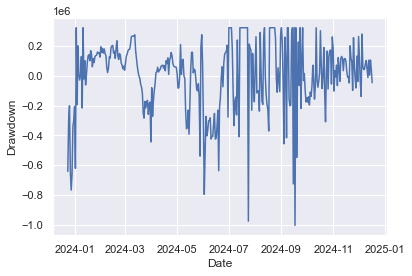

In [1143]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Drawdown':y_pred_future})
plt = sns.lineplot(data=df_forecast, x='Date', y='Drawdown')
df_forecast.set_index('Date', inplace=True)

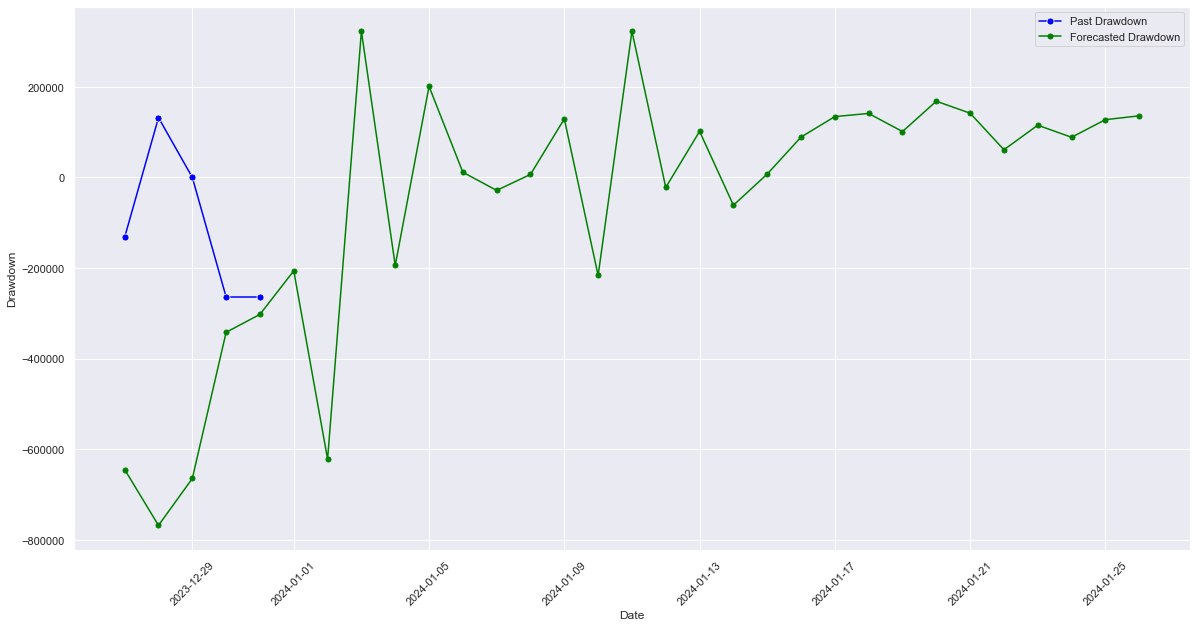

In [1144]:
import seaborn as sns
import matplotlib.pyplot as plt

# For the past data
original = data[['Drawdown']]
original = original.loc[(original.index >= original.index[-5]) & (original.index <= original.index[-1])]

# For the forecasted data plot
last_known_date = original.index[-1]
start_date = last_known_date + pd.Timedelta(days=-4)
forecast_end_date = start_date + pd.Timedelta(days=30)
forecast_dates = pd.date_range(start=start_date, end=forecast_end_date)
forecast_values = df_forecast.loc[forecast_dates, 'Drawdown']

# Connect the past data to the forecasted data
last_known_value = original['Drawdown'].iloc[-1]

# Plotting
sns.set(rc={'figure.figsize':(20, 10)})
sns.lineplot(data=original, x=original.index, y='Drawdown', color='blue', marker='o', markersize=7, label='Past Drawdown')
plt.plot(forecast_dates, forecast_values, label='Forecasted Drawdown', color='green', marker='o', markersize=5)


plt.xticks(rotation=45)
plt.legend()
plt.show()


In [1145]:
actual_drawdown_error = abs(df_forecast['Drawdown'].iloc[7] - original['Drawdown'].iloc[-1])
act_percentage_drawdown_error = actual_drawdown_error / (abs(original['Drawdown'].iloc[-1]) + abs(df_forecast['Drawdown'].iloc[7]))
act_drawdown_smape = 100 * np.mean(act_percentage_drawdown_error)
act_drawdown_smape = 100 - act_drawdown_smape
act_drwodown_smape = round(act_drawdown_smape,2)
act_drawdown_smape

93.23515389097844

In [1146]:
f_drawdown_error = abs(test_predictions - y_test_inv)
f_percentage_drawdown_error = f_drawdown_error / (abs(y_test_inv) + abs(test_predictions))
f_drawdown_smape = 100 * np.mean(f_percentage_drawdown_error)
f_drawdown_smape = 100 - f_drawdown_smape
f_drwodown_smape = round(f_drawdown_smape,2)
f_drawdown_smape

38.25941378733945

In [1147]:
df_forecast.head(15)

,Drawdown
Date,
2023-12-24,-642182.687500
2023-12-25,-300778.125000
2023-12-26,-202005.843750
2023-12-27,-644888.187500
2023-12-28,-768168.250000
2023-12-29,-664642.250000
2023-12-30,-341892.031250
2023-12-31,-302310.000000
2024-01-01,-206247.171875


In [1148]:
original.tail(10)

,Drawdown
Date,
2023-12-27,-132000.0
2023-12-28,132000.0
2023-12-29,0.0
2023-12-30,-264000.0
2023-12-31,-264000.0


In [1149]:
df_forecast['Drawdown'].iloc[6]

-341892.03